<a href="https://colab.research.google.com/github/thelastbeto/Recommendation_System/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a046fef41212a39939c5a742dd4043b8957fe23751e3fcd567e377b33cf28cf2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
! pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 2.6 MB/s eta 0:00:00


In [3]:
from pyspark.sql import SparkSession

session = SparkSession.builder\
.appName("Final Project - Recommendation System With PySpark")\
.getOrCreate()

session

In [4]:
from pyspark import SparkFiles

url_dados = 'https://github.com/thelastbeto/Recommendation_System/blob/main/dados_musicas.csv?raw=true'
session.sparkContext.addFile(url_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas.csv')

dados = session.read.csv(path_dados_file, header=True, sep=';', inferSchema=True)

In [5]:
import pyspark.sql.functions as f

dados.select([f.count(f.when(f.isnull(c), 1)). alias(c)for c in dados.columns]).show()


+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|speechiness|tempo|artists_song|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|          0|    0|           0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+



In [6]:
import plotly.express as px
import plotly.graph_objects as go
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array as va

# Clusterização por música

In [7]:
x = dados.columns
x.remove('artists')
x.remove('id')
x.remove('name')
x.remove('artists_song')
x

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

In [8]:
dados_encoded_vector = VectorAssembler(inputCols=x, outputCol = 'features').transform(dados)

In [9]:
def stan_scaler(dados):
  scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
  model_scaler = scaler.fit(dados)
  dados_musicas_scaler = model_scaler.transform(dados)
  dados_musicas_scaler.select('features_scaled').show(truncate=False, n=5)
  return dados_musicas_scaler

dados_musicas_scaler = stan_scaler(dados_encoded_vector)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.156596679221045,329.8170613984441,0.008403188822334736,2.5040545743834373,3.7858811737298526,2.980511298201045,0.0,6.070790766862789E-4,3.0696424994844875,1.4832857988766257,-1.

In [10]:
k = len(x)

pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicais_pca = model_pca.transform(dados_musicas_scaler)
dados_musicais_pca.select(['pca_features']).show()



+--------------------+
|        pca_features|
+--------------------+
|[-34.710044647757...|
|[-36.498857627749...|
|[-35.460300916940...|
|[-35.563013255205...|
|[-36.545569749075...|
|[-36.713222290262...|
|[-36.013246178822...|
|[-36.542687712104...|
|[-36.425249009784...|
|[-35.872074915770...|
|[-31.639065936568...|
|[-35.661446890546...|
|[-35.574542234850...|
|[-36.022399748656...|
|[-34.336941950985...|
|[-35.096906055142...|
|[-35.202423054032...|
|[-34.942948671026...|
|[-36.617404517517...|
|[-34.296973387410...|
+--------------------+
only showing top 20 rows



In [11]:
import numpy as np

model_pca.explainedVariance
sum(model_pca.explainedVariance) * 100

lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
lista_valores

k = sum(np.array(lista_valores) <= 0.7)
k

pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca_final = model_pca.transform(dados_musicas_scaler)

dados_musicas_pca_final.select('pca_features').show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
+-------------------------------

In [12]:
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=x, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='features_scaled'),
                                PCA(k=6, inputCol='features_scaled', outputCol='pca_features')])

model_pca_pipeline = pca_pipeline.fit(dados)
projection = model_pca_pipeline.transform(dados)
projection.select('pca_features').show(truncate=False, n=5)

kmeans = KMeans(k=50, featuresCol= 'pca_features', predictionCol='cluster_pca', seed=101)
modelo_kmeans = kmeans.fit(projection)
projection_kmeans = modelo_kmeans.transform(projection)



+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
+-------------------------------

In [13]:
projection_kmeans = projection_kmeans.withColumn('x', va('pca_features')[0])\
.withColumn('y', va('pca_features')[1])

In [14]:
model_pca_pipeline = pca_pipeline.fit(dados)
projection = model_pca_pipeline.transform(dados)
projection.select('pca_features').show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
+-------------------------------

In [15]:


def vem_cluster(k):
    kmeans = KMeans(k=k, featuresCol='pca_features', predictionCol='cluster_pca', seed=101)
    modelo_kmeans = kmeans.fit(projection)
    projection_kmeans = modelo_kmeans.transform(projection)
    projection_kmeans = projection_kmeans.withColumn('x', va('pca_features')[0])\
                                  .withColumn('y', va('pca_features')[1])


# Sistema de Recomendação

In [16]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [17]:
nome_musica = 'Logic - Nikki'

cluster = projection_kmeans.filter(projection_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]

musicas_recomendadas = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')

componentes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
.select('pca_features').collect()[0][0]

In [18]:
def calcula_distance(valor):
  return euclidean(componentes_musica, valor)


udf_calcula_distance = f.udf(calcula_distance, FloatType())
musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))
musicas_recomendadas_dist.sort('Dist').take(10)
recomendadas = session.createDataFrame(musicas_recomendadas_dist.sort('Dist'). take(10)).select(['artists_song', 'id', 'Dist'])
recomendadas.show()

+--------------------+--------------------+------------------+
|        artists_song|                  id|              Dist|
+--------------------+--------------------+------------------+
|       Logic - Nikki|1JFx9R87En9oJOi4D...|               0.0|
|Justin Bieber - W...|1m6FkAtWVloxIRHKl...|0.5726701617240906|
|Justin Timberlake...|4mQVHEjrnuUd7G5IV...|0.7134919166564941|
|Disclosure - Magnets|7nRmfGNhHKEEu5o8y...|0.8693515062332153|
|J Balvin - Mi Gen...|0GzmMQizDeA2NVMUa...|0.9040448069572449|
|Kid Cudi - By Design|5FxVTEpoBress37Mm...|0.9169051647186279|
|Kanye West - Hear...|4EWCNWgDS8707fNSZ...|0.9247043132781982|
|      Plan B - Candy|2ctjDCCg1wHoQSjIJ...|0.9281526207923889|
|Sia - Cheap Thril...|6b3b7lILUJqXcp6w9...|1.0385602712631226|
|David Guetta - Sa...|3MoV1UsAJmz64LHqy...|1.0628212690353394|
+--------------------+--------------------+------------------+



In [19]:
def recomendador(nome_musica):
  cluster = projection_kmeans.filter(projection_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')
  componentes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
  .select('pca_features').collect()[0][0]


  def calcula_distance(valor):
    return euclidean(componentes_musica, valor)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())
  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))
  musicas_recomendadas_dist.sort('Dist').take(10)
  recomendadas = session.createDataFrame(musicas_recomendadas_dist.sort('Dist'). take(10)).select(['artists_song', 'id', 'Dist'])
  recomendadas.select('artists_song').show(truncate=False)


recomendador('Logic - Nikki')

+-------------------------------------------------------------------------+
|artists_song                                                             |
+-------------------------------------------------------------------------+
|Logic - Nikki                                                            |
|Justin Bieber - We Are                                                   |
|Justin Timberlake - Suit & Tie (feat. JAY Z) (feat. Jay-Z) - [Radio Edit]|
|Disclosure - Magnets                                                     |
|J Balvin - Mi Gente (feat. Beyoncé)                                      |
|Kid Cudi - By Design                                                     |
|Kanye West - Heartless                                                   |
|Plan B - Candy                                                           |
|Sia - Cheap Thrills (feat. Sean Paul)                                    |
|David Guetta - Say My Name                                               |
+-----------

In [20]:
def encontra_musica(nome_musica, projection_m):
  resultado = projection_m.filter(projection_m.artists_song == nome_musica).collect()
  if len(resultado) == 0:
    return False
  return True

# Spotipy

In [21]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials

In [22]:
scope = "user-library-read playlist-modify-private"

OAuth = SpotifyOAuth(
        scope=scope,
        redirect_uri='http://localhost:5000/callback',
         client_id = YOUR_ID_SPOTIFY,
        client_secret = YOUR_SECRET_SPOTIFY)



client_credentials_manager = SpotifyClientCredentials(client_id = YOUR_ID_SPOTIFY,
                                                      client_secret = YOUR_SECRET_SPOTIFY)

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [24]:
id = projection_kmeans.filter(projection_kmeans.artists_song == nome_musica).select('id').collect()[0][0]

sp.track(id)

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4xRYI6VqpkE3UwrDrAZL8L'},
    'href': 'https://api.spotify.com/v1/artists/4xRYI6VqpkE3UwrDrAZL8L',
    'id': '4xRYI6VqpkE3UwrDrAZL8L',
    'name': 'Logic',
    'type': 'artist',
    'uri': 'spotify:artist:4xRYI6VqpkE3UwrDrAZL8L'}],
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',
   'UY',
   'US',
   'GB',
   'AD',
   'LI',
   'MC',
   'ID',
   'JP',
   'TH',
   'VN',
   'RO',
   'IL',
   'ZA',
   'SA',
   'AE',
   'BH',
   'QA',
   'OM',
   'KW

In [25]:
import matplotlib.pyplot as plt
from skimage import io


def recomendador(nome_musica):
  # Calcula musicas recomendadas.
  cluster = projection_kmeans.filter(projection_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster).select('artists_song', 'id', 'pca_features')
  componentes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
  .select('pca_features').collect()[0][0]

  def calcula_distance(valor):
    return euclidean(componentes_musica, valor)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())
  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))
  musicas_recomendadas_dist.sort('Dist').take(10)
  recomendadas = session.createDataFrame(musicas_recomendadas_dist.sort('Dist'). take(10)).select(['artists_song', 'id', 'Dist'])

  # Pegar informações da API do Spotify

  playlist_id = recomendadas.select('id').collect()

  name = []
  url = []
  for i in playlist_id:
    track = sp.track(i[0])
    url.append(track["album"]["images"][1]["url"])
    name.append(track["name"])

  # Plotando capas:
  plt.figure(figsize=(15,10))
  columns = 5
  for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
        image = io.imread(u)
        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(name[i], fontsize = 10)
        plt.tight_layout(h_pad=0.7, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.grid(visible=None)
        #plt.axis('off')
  plt.show()

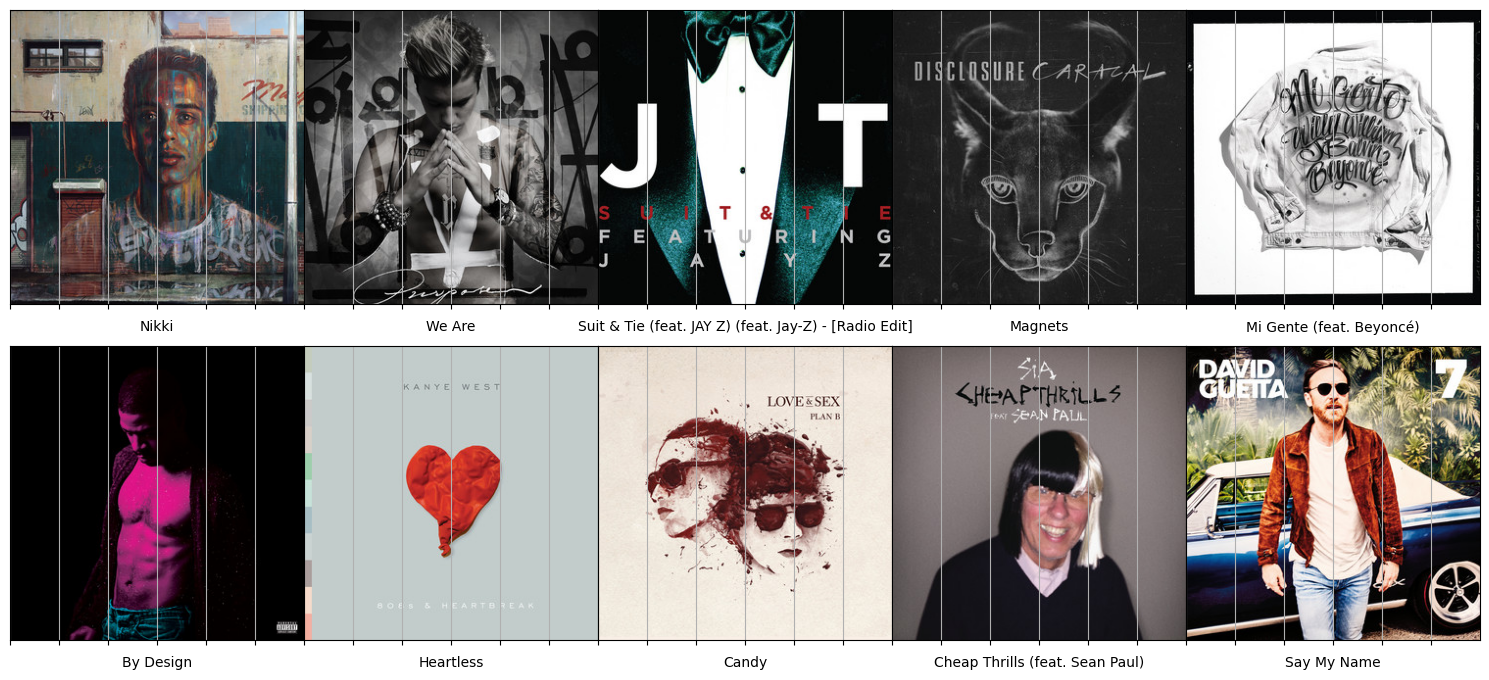

In [26]:
recomendador('Logic - Nikki')